In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Load Data

In [ ]:
df = pd.read_csv(r"C:\Users\Kshitij\Downloads\F1\f1_stint_data_2020_2024.csv")
df.head()

,EventName,RoundNumber,EventYear,Team,Driver,GridPosition,FinalPosition,Compound,StintLen,CircuitLength,...,StintEndLap,AvgLapTime,TrackTemp,AirTemp,Humidity,Rainfall,DegradationSlope,DegradationBias,SafetyCar,PositionsDelta
0,Austrian Grand Prix,1,2020,Mercedes,Valtteri Bottas,1,1,SOFT,22,4318,...,22.0,70.243955,52.025,28.684167,33.8325,0,0.174003,68.416925,0,0
1,Austrian Grand Prix,1,2020,Mercedes,Valtteri Bottas,1,1,HARD,30,4318,...,52.0,81.737000,52.025,28.684167,33.8325,0,0.052781,80.971671,0,0
2,Austrian Grand Prix,1,2020,Mercedes,Valtteri Bottas,1,1,HARD,16,4318,...,68.0,78.694400,52.025,28.684167,33.8325,0,-3.153004,100.765425,0,0
3,Austrian Grand Prix,1,2020,Ferrari,Charles Leclerc,7,2,SOFT,21,4318,...,21.0,71.545952,52.025,28.684167,33.8325,0,0.149890,70.047056,0,5
4,Austrian Grand Prix,1,2020,Ferrari,Charles Leclerc,7,2,HARD,25,4318,...,46.0,76.204240,52.025,28.684167,33.8325,0,-1.145312,89.947978,0,5


# Feature Engineering

In [5]:
#Add stint_number
df['stint_num'] = df.groupby(['EventName', 'RoundNumber', 'EventYear', 'Team', 'Driver']).cumcount() + 1

# Add total number of stints
grouped = df.groupby(['EventName','EventYear','Driver'])
strategy_data = grouped.apply(lambda x: pd.Series({
    'num_stints': len(x),
    'stint_compounds': list(x['Compound']),
    'stint_lengths': list(x['StintLen'])
})).reset_index()
merged_data = pd.merge(df, strategy_data, on=['EventName', 'EventYear', 'Driver'])

# Remove data where number of Stints is 1
merged_data = merged_data[merged_data['num_stints'] != 1]

#Encode categorical variables
le_event = LabelEncoder()
le_compound = LabelEncoder()

merged_data['EventEncoded'] = le_event.fit_transform(merged_data['EventName'])
merged_data['CompoundEncoded'] = le_compound.fit_transform(merged_data['Compound'])

#Remove data in which number of stints is more than 5 or less than 1
merged_data=merged_data[merged_data['num_stints']!=1]
merged_data=merged_data[merged_data['num_stints']<5]

#Removing data in which stint lentgh is more than 35 or less than 5
merged_data = merged_data[merged_data['StintLen']>5]
merged_data = merged_data[merged_data['StintLen']<35]

#Create temporal features
merged_data['prev_stint_length'] = merged_data.groupby(['EventName', 'EventYear', 'Driver'])['StintLen'].shift(1)
merged_data['cumulative_laps'] = merged_data.groupby(['EventName', 'EventYear', 'Driver'])['StintLen'].cumsum()
merged_data.fillna(0, inplace=True)

merged_data.head()

C:\Users\Kshitij\AppData\Local\Temp\ipykernel_11880\936524280.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  strategy_data = grouped.apply(lambda x: pd.Series({


,EventName,RoundNumber,EventYear,Team,Driver,GridPosition,FinalPosition,Compound,StintLen,CircuitLength,...,SafetyCar,PositionsDelta,stint_num,num_stints,stint_compounds,stint_lengths,EventEncoded,CompoundEncoded,prev_stint_length,cumulative_laps
0,Austrian Grand Prix,1,2020,Mercedes,Valtteri Bottas,1,1,SOFT,22,4318,...,0,0,1,3,"[SOFT, HARD, HARD]","[22, 30, 16]",3,3,0.0,22
1,Austrian Grand Prix,1,2020,Mercedes,Valtteri Bottas,1,1,HARD,30,4318,...,0,0,2,3,"[SOFT, HARD, HARD]","[22, 30, 16]",3,0,22.0,52
2,Austrian Grand Prix,1,2020,Mercedes,Valtteri Bottas,1,1,HARD,16,4318,...,0,0,3,3,"[SOFT, HARD, HARD]","[22, 30, 16]",3,0,30.0,68
3,Austrian Grand Prix,1,2020,Ferrari,Charles Leclerc,7,2,SOFT,21,4318,...,0,5,1,4,"[SOFT, HARD, MEDIUM, MEDIUM]","[21, 25, 5, 15]",3,3,0.0,21
4,Austrian Grand Prix,1,2020,Ferrari,Charles Leclerc,7,2,HARD,25,4318,...,0,5,2,4,"[SOFT, HARD, MEDIUM, MEDIUM]","[21, 25, 5, 15]",3,0,21.0,46


In [6]:
merged_data.columns

Index(['EventName', 'RoundNumber', 'EventYear', 'Team', 'Driver',
       'GridPosition', 'FinalPosition', 'Compound', 'StintLen',
       'CircuitLength', 'DesignedLaps', 'StintStartLap', 'StintEndLap',
       'AvgLapTime', 'TrackTemp', 'AirTemp', 'Humidity', 'Rainfall',
       'DegradationSlope', 'DegradationBias', 'SafetyCar', 'PositionsDelta',
       'stint_num', 'num_stints', 'stint_compounds', 'stint_lengths',
       'EventEncoded', 'CompoundEncoded', 'prev_stint_length',
       'cumulative_laps'],
      dtype='object')

# Features that will be used for training

In [7]:
features_stint_num = ['CircuitLength', 'DesignedLaps','TrackTemp', 'AirTemp','EventEncoded'] 
features_stint_compound = ['CircuitLength', 'cumulative_laps', 'TrackTemp', 'AirTemp','stint_num','EventEncoded','Humidity', 'Rainfall','SafetyCar']
features_stint_length = ['CircuitLength', 'TrackTemp', 'AirTemp','prev_stint_length','EventEncoded','DegradationSlope', 'DegradationBias','DesignedLaps','Humidity', 'Rainfall','SafetyCar']

### Target variables

In [8]:
target_total_stints = 'num_stints'
target_compound = 'CompoundEncoded'
target_stint_len = 'StintLen'

# Model Training

### Model for Total Number of Stints

In [9]:
X_stint_count = merged_data.drop_duplicates(subset=['EventName', 'EventYear', 'Driver'])[features_stint_num]
y_stint_count = merged_data.drop_duplicates(subset=['EventName', 'EventYear', 'Driver'])[target_total_stints]

X_compound = merged_data[features_stint_compound]
y_compound = merged_data[target_compound]

In [10]:
X_train_stint_count, X_test_stint_count, y_train_stint_count, y_test_stint_count = train_test_split(X_stint_count,y_stint_count, test_size=0.2, random_state=42)

stint_count_model = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.02)
stint_count_model.fit(X_train_stint_count,y_train_stint_count,eval_set=[(X_train_stint_count,y_train_stint_count),(X_test_stint_count,y_test_stint_count)])

[0]	validation_0-rmse:0.70703	validation_1-rmse:0.70081
[1]	validation_0-rmse:0.70119	validation_1-rmse:0.69554
[2]	validation_0-rmse:0.69533	validation_1-rmse:0.69020
[3]	validation_0-rmse:0.68965	validation_1-rmse:0.68502
[4]	validation_0-rmse:0.68401	validation_1-rmse:0.67982
[5]	validation_0-rmse:0.67854	validation_1-rmse:0.67479
[6]	validation_0-rmse:0.67352	validation_1-rmse:0.67032
[7]	validation_0-rmse:0.66837	validation_1-rmse:0.66560
[8]	validation_0-rmse:0.66338	validation_1-rmse:0.66110
[9]	validation_0-rmse:0.65854	validation_1-rmse:0.65680
[10]	validation_0-rmse:0.65433	validation_1-rmse:0.65293
[11]	validation_0-rmse:0.65026	validation_1-rmse:0.64918
[12]	validation_0-rmse:0.64632	validation_1-rmse:0.64557
[13]	validation_0-rmse:0.64251	validation_1-rmse:0.64208
[14]	validation_0-rmse:0.63882	validation_1-rmse:0.63871
[15]	validation_0-rmse:0.63524	validation_1-rmse:0.63545
[16]	validation_0-rmse:0.63179	validation_1-rmse:0.63233
[17]	validation_0-rmse:0.62844	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

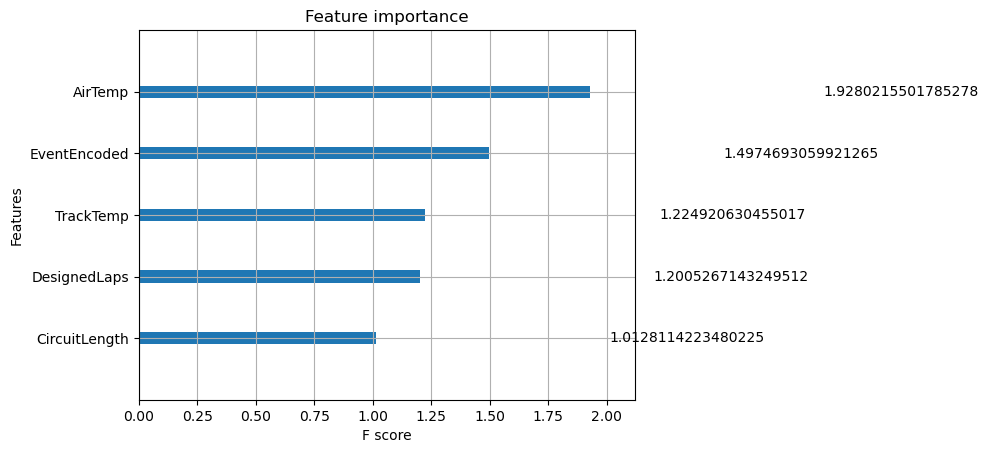

In [11]:
xgb.plot_importance(stint_count_model, importance_type='gain') 

### Models For Stint Compound

In [12]:
s1_df = merged_data[merged_data['stint_num']==1]
s1_df = s1_df[features_stint_compound]

s2_df = merged_data[merged_data['stint_num']==2]
s2_df = s2_df[features_stint_compound]

s3_df = merged_data[merged_data['stint_num']==3]
s3_df = s3_df[features_stint_compound]

s4_df = merged_data[merged_data['stint_num']==4]
s4_df = s4_df[features_stint_compound]

In [13]:
y_s1 = merged_data.loc[merged_data['stint_num'] == 1][target_compound]
y_s2 = merged_data.loc[merged_data['stint_num'] == 2][target_compound]
y_s3 = merged_data.loc[merged_data['stint_num'] == 3][target_compound]
y_s4 = merged_data.loc[merged_data['stint_num'] == 4][target_compound]

In [14]:
X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(s1_df, y_s1, test_size=0.2, random_state=42)
X_s2_train, X_s2_test, y_s2_train, y_s2_test = train_test_split(s2_df, y_s2, test_size=0.2, random_state=42)
X_s3_train, X_s3_test, y_s3_train, y_s3_test = train_test_split(s3_df, y_s3, test_size=0.2, random_state=42)
X_s4_train, X_s4_test, y_s4_train, y_s4_test = train_test_split(s4_df, y_s4, test_size=0.2, random_state=42)

In [15]:
def train_compound_model(X_train, y_train, X_test, y_test, stint_num):
    print(f"\nTraining model for Stint {stint_num}...")

    model = xgb.XGBClassifier(
        n_estimators=1500,
        early_stopping_rounds=50,
        learning_rate=0.01,
        random_state=42,
        max_depth = 5,
        objective = 'multi:softprob',
        num_class = 5,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    return model

In [16]:
stint_1_compound_model = train_compound_model(X_s1_train, y_s1_train, X_s1_test, y_s1_test, stint_num=1)
stint_2_compound_model = train_compound_model(X_s2_train, y_s2_train, X_s2_test, y_s2_test, stint_num=2)
stint_3_compound_model = train_compound_model(X_s3_train, y_s3_train, X_s3_test, y_s3_test, stint_num=3)
stint_4_compound_model = train_compound_model(X_s4_train, y_s4_train, X_s4_test, y_s4_test, stint_num=4)


Training model for Stint 1...
[0]	validation_0-mlogloss:1.59504	validation_1-mlogloss:1.59633
[100]	validation_0-mlogloss:0.86668	validation_1-mlogloss:0.93526
[200]	validation_0-mlogloss:0.61240	validation_1-mlogloss:0.71380
[300]	validation_0-mlogloss:0.49825	validation_1-mlogloss:0.62342
[400]	validation_0-mlogloss:0.43574	validation_1-mlogloss:0.57948
[500]	validation_0-mlogloss:0.39483	validation_1-mlogloss:0.55303
[600]	validation_0-mlogloss:0.36582	validation_1-mlogloss:0.53868
[700]	validation_0-mlogloss:0.34279	validation_1-mlogloss:0.53228
[800]	validation_0-mlogloss:0.32407	validation_1-mlogloss:0.52926
[900]	validation_0-mlogloss:0.30848	validation_1-mlogloss:0.52885
[963]	validation_0-mlogloss:0.30028	validation_1-mlogloss:0.52981

Training model for Stint 2...
[0]	validation_0-mlogloss:1.59673	validation_1-mlogloss:1.59805
[100]	validation_0-mlogloss:0.93381	validation_1-mlogloss:1.00532
[200]	validation_0-mlogloss:0.70877	validation_1-mlogloss:0.80610
[300]	validation_0

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

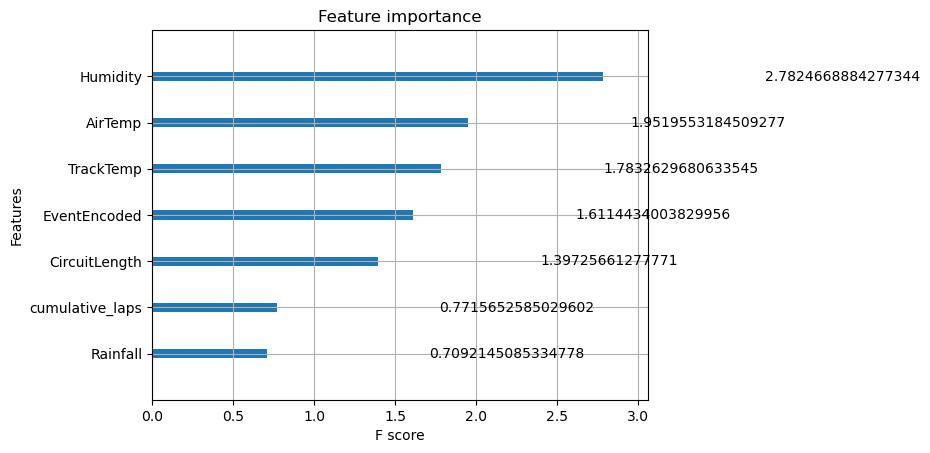

In [17]:
xgb.plot_importance(stint_1_compound_model, importance_type='gain')

### Models for Stint Length 

In [18]:
s1_len_df = merged_data[merged_data['stint_num']==1]
s1_len_df = s1_len_df[features_stint_length]

s2_len_df = merged_data[merged_data['stint_num']==2]
s2_len_df = s2_len_df[features_stint_length]

s3_len_df = merged_data[merged_data['stint_num']==3]
s3_len_df = s3_len_df[features_stint_length]

s4_len_df = merged_data[merged_data['stint_num']==4]
s4_len_df = s4_len_df[features_stint_length]

In [19]:
y_s1_len = merged_data.loc[merged_data['stint_num'] == 1][target_stint_len]
y_s2_len = merged_data.loc[merged_data['stint_num'] == 2][target_stint_len]
y_s3_len = merged_data.loc[merged_data['stint_num'] == 3][target_stint_len]
y_s4_len = merged_data.loc[merged_data['stint_num'] == 4][target_stint_len]

In [20]:
X_s1_len_train, X_s1_len_test, y_s1_len_train, y_s1_len_test = train_test_split(s1_len_df, y_s1_len, test_size=0.2, random_state=42)
X_s2_len_train, X_s2_len_test, y_s2_len_train, y_s2_len_test = train_test_split(s2_len_df, y_s2_len, test_size=0.2, random_state=42)
X_s3_len_train, X_s3_len_test, y_s3_len_train, y_s3_len_test = train_test_split(s3_len_df, y_s3_len, test_size=0.2, random_state=42)
X_s4_len_train, X_s4_len_test, y_s4_len_train, y_s4_len_test = train_test_split(s4_len_df, y_s4_len, test_size=0.2, random_state=42)

In [21]:
def train_stint_len_model(X_train, y_train, X_test, y_test, stint_num):
    print(f"\nTraining model for Stint {stint_num}...")

    model = xgb.XGBRegressor(
        n_estimators=1500,
        early_stopping_rounds=50,
        learning_rate=0.01,
        random_state=42,
        max_depth = 5
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    return model

In [22]:
stint_1_len_model = train_stint_len_model(X_s1_len_train, y_s1_len_train, X_s1_len_test, y_s1_len_test, stint_num=1)
stint_2_len_model = train_stint_len_model(X_s2_len_train, y_s2_len_train, X_s2_len_test, y_s2_len_test, stint_num=2)
stint_3_len_model = train_stint_len_model(X_s3_len_train, y_s3_len_train, X_s3_len_test, y_s3_len_test, stint_num=3)
stint_4_len_model = train_stint_len_model(X_s4_len_train, y_s4_len_train, X_s4_len_test, y_s4_len_test, stint_num=4)


Training model for Stint 1...
[0]	validation_0-rmse:7.45173	validation_1-rmse:7.72781


[100]	validation_0-rmse:5.45452	validation_1-rmse:5.72958
[200]	validation_0-rmse:4.66465	validation_1-rmse:5.04371
[300]	validation_0-rmse:4.25138	validation_1-rmse:4.69271
[400]	validation_0-rmse:4.00130	validation_1-rmse:4.49621
[500]	validation_0-rmse:3.82345	validation_1-rmse:4.35102
[600]	validation_0-rmse:3.62926	validation_1-rmse:4.22152
[700]	validation_0-rmse:3.44895	validation_1-rmse:4.12246
[800]	validation_0-rmse:3.28653	validation_1-rmse:4.06404
[900]	validation_0-rmse:3.13926	validation_1-rmse:3.99902
[1000]	validation_0-rmse:2.99054	validation_1-rmse:3.96811
[1100]	validation_0-rmse:2.86353	validation_1-rmse:3.92964
[1200]	validation_0-rmse:2.76629	validation_1-rmse:3.91022
[1300]	validation_0-rmse:2.64683	validation_1-rmse:3.89984
[1400]	validation_0-rmse:2.54440	validation_1-rmse:3.90541
[1404]	validation_0-rmse:2.53972	validation_1-rmse:3.90506

Training model for Stint 2...
[0]	validation_0-rmse:7.12994	validation_1-rmse:6.76628
[100]	validation_0-rmse:5.07437	valid

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

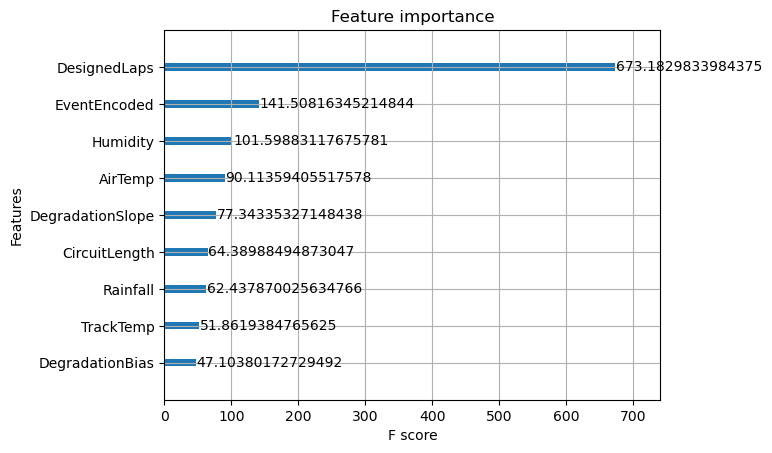

In [23]:
xgb.plot_importance(stint_1_len_model, importance_type='gain')

# Example Usage

In [24]:
new_race_data = {
    'CircuitLength': 4309,         # From the data
    'DesignedLaps': 71,            # From the data
    'TrackTemp': 51.56139240506329,  # Avg of track temps
    'AirTemp': 23.1373417721519,     # Avg of air temps
    'Humidity': 60.10126582278481,   # Humidity
    'Rainfall': 0,                  # No rainfall mentioned
    'SafetyCar': 0,                 # Assuming no safety car deployment
    
    # Degradation Slopes and Biases for each compound
    'DegradationSlope_s': -23,          # No SOFT stint data available
    'DegradationBias_s': 94.2,           # No SOFT stint data available
    
    'DegradationSlope_m': -1.5,        # From MEDIUM stint
    'DegradationBias_m': 95,          # From MEDIUM stint
    
    'DegradationSlope_h': -0.8,       # From HARD stint
    'DegradationBias_h': 83,          # From HARD stint
    
    # Encode the event name
    'EventEncoded': le_event.transform(['São Paulo Grand Prix'])[0]
}


new_race_df = pd.DataFrame([new_race_data])

In [25]:
X_stint_count = new_race_df[features_stint_num]
predicted_total_stints = int(stint_count_model.predict(X_stint_count)[0])
print(f"\n🔧 Predicted Total Stints: {predicted_total_stints}")
new_race_df['num_stints'] = predicted_total_stints


🔧 Predicted Total Stints: 3


In [30]:
# Mapping of compound name to degradation slope and bias column names
degradation_mapping = {
    'SOFT': ('DegradationSlope_s', 'DegradationBias_s'),
    'MEDIUM': ('DegradationSlope_m', 'DegradationBias_m'),
    'HARD': ('DegradationSlope_h', 'DegradationBias_h')
}

# Stint compound prediction models (ordered)
compound_models = [
    stint_1_compound_model,
    stint_2_compound_model,
    stint_3_compound_model,
    stint_4_compound_model
]

# Stint length prediction models (ordered)
length_models = [
    stint_1_len_model,
    stint_2_len_model,
    stint_3_len_model,
    stint_4_len_model
]

cum_laps = 0
prev_stint_len = 0
predicted_stint_lengths = []
predicted_compounds = []

# Loop through all predicted stints
for stint_num in range(predicted_total_stints):
    new_race_df['stint_num'] = stint_num + 1
    new_race_df['cumulative_laps'] = cum_laps
    new_race_df['prev_stint_length'] = prev_stint_len

    try:
        compound_model = compound_models[stint_num]
    except IndexError:
        print(f"No compound model available for stint {stint_num + 1}. Skipping.")
        break

    # Predict compound
    stint_compound_encoded = compound_model.predict(new_race_df[features_stint_compound])[0]
    compound_name = le_compound.inverse_transform([stint_compound_encoded])[0]
    
    predicted_compounds.append(compound_name)
    
    deg_slope_col, deg_bias_col = degradation_mapping.get(compound_name, (None, None))
    
    if deg_slope_col is None or deg_bias_col is None:
        print(f"Unknown compound '{compound_name}' for stint {stint_num + 1}. Skipping degradation update.")
        break
    
    new_race_df['DegradationSlope'] = new_race_df[deg_slope_col]
    new_race_df['DegradationBias'] = new_race_df[deg_bias_col]
    
    new_race_df['CompoundEncoded'] = stint_compound_encoded
    
    try:
        length_model = length_models[stint_num]
        stint_length = int(length_model.predict(new_race_df[features_stint_length])[0])
        
        if stint_length <= 0:
            stint_length = 1
        
        cum_laps += stint_length
        prev_stint_len = stint_length
        
        predicted_stint_lengths.append(stint_length)
        
    except IndexError:
        print(f"No length model available for stint {stint_num + 1}. Skipping length prediction.")
        break

# -----------------------------
# 🔧 Fix last stint length!
# -----------------------------
total_laps = int(new_race_df['DesignedLaps'].iloc[0])
laps_difference = total_laps - cum_laps

if laps_difference != 0 and predicted_stint_lengths:
    predicted_stint_lengths[-1] += laps_difference
    cum_laps = total_laps
# -----------------------------
# ⚠️ Enforce Different Compounds (One change only)
# -----------------------------
unique_compounds = set(predicted_compounds)

if len(unique_compounds) == 1:

    current_compound = predicted_compounds[0]

    # Find the indices of the longest and shortest stints
    longest_stint_index = predicted_stint_lengths.index(max(predicted_stint_lengths))
    shortest_stint_index = predicted_stint_lengths.index(min(predicted_stint_lengths))

    # Flag to know if a switch was made
    switch_made = False

    # -----------------------------
    # Priority 1: Try switching longest stint to HARD
    # -----------------------------
    if current_compound != 'HARD':
        if predicted_compounds[longest_stint_index] != 'HARD':
            predicted_compounds[longest_stint_index] = 'HARD'
            switch_made = True

    # -----------------------------
    # Priority 2: If no switch was made, try switching shortest stint to SOFT
    # -----------------------------
    if not switch_made and current_compound != 'SOFT':
        if predicted_compounds[shortest_stint_index] != 'SOFT':
            predicted_compounds[shortest_stint_index] = 'SOFT'
            switch_made = True

    if not switch_made:
        print("⚠️ Could not enforce different compounds due to current compound already being SOFT/HARD.")

    #  Update degradation slopes/biases if necessary
    for idx, compound_name in enumerate(predicted_compounds):
        deg_slope_col, deg_bias_col = degradation_mapping[compound_name]

# -----------------------------
# ✅ Final Output
# -----------------------------
print('=' * 50)
print("📋 Final Predicted Strategy")
print('-' * 50)

for i, (compound, length) in enumerate(zip(predicted_compounds, predicted_stint_lengths), start=1):
    print(f"Stint {i}: {length} laps on {compound}")

print('-' * 50)
print(f"Total Laps Covered: {cum_laps} / {total_laps}")
print('=' * 50)


📋 Final Predicted Strategy
--------------------------------------------------
Stint 1: 18 laps on MEDIUM
Stint 2: 11 laps on MEDIUM
Stint 3: 42 laps on HARD
--------------------------------------------------
Total Laps Covered: 71 / 71
